In [1]:
import sys
import os
import matplotlib.pyplot as plt

# TFC training

In [2]:
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/model')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/trainer')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/dataloader')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/SleepEEG_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/HAR_Configs')


In [3]:
import torch
from torch import nn
from model import TFC, target_classifier
from dataloader import data_generator
from trainer import model_pretrain


In [4]:
torch.backends.mps.is_available()

True

### define configs

In [5]:
from SleepEEG_Configs import Config as Configs

SEED = 42
arch = 'sleep_EEG'
save_model_path = 'experiment_logs/pretrainmodel/'
sourcedata_path = '../datasets/SleepEEG/'
targetdata_path = '../datasets/Epilepsy/'

In [6]:
# from HAR_Configs import Config as Configs

# SEED = 42
# arch = 'HAR'
# save_model_path = 'experiment_logs/pretrainmodel/'
# sourcedata_path = '../datasets/HAR/'
# targetdata_path = '../datasets/Gesture/'

In [7]:
training_mode = 'pre_train'
subset = False


device = torch.device("mps")
configs = Configs()

### create TFC model and finetuning classifier

In [8]:
TFC_model = TFC(configs).to(device)

### create optimizers

In [9]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min')

### load datasets

In [10]:
train_dl, valid_dl, test_dl = data_generator(sourcedata_path, targetdata_path, configs, training_mode, subset=subset)

### finetune and test loop

In [11]:
### Pretraining on source dataset

for epoch in range(1, configs.num_epoch + 1):

    train_loss = model_pretrain(TFC_model, model_optimizer, criterion, train_dl, configs, device, training_mode)


os.makedirs(save_model_path, exist_ok=True)
chkpoint = {'model_state_dict': TFC_model.state_dict()}
torch.save(chkpoint, os.path.join(save_model_path, f'{arch}_ckp_last.pt'))

/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/loss.py:119: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)


Pretraining: overall loss:8.99191951751709, l_t: 5.724876403808594, l_f:6.539056301116943, l_c:6.539132595062256
Pretraining: overall loss:9.03248405456543, l_t: 5.924015045166016, l_f:6.539329528808594, l_c:6.539815425872803


KeyboardInterrupt: 

### visualise embeddings of training set

In [19]:
from sklearn.manifold import TSNE

In [29]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [30]:
h_t, z_t, h_f, z_f = TFC_model(data.to(torch.float32).to(device), data_f.to(torch.float32).to(device))
fea_concat = torch.cat((z_t, z_f), dim=1)
fea_concat = fea_concat.to('cpu').detach().numpy()

In [31]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(fea_concat)

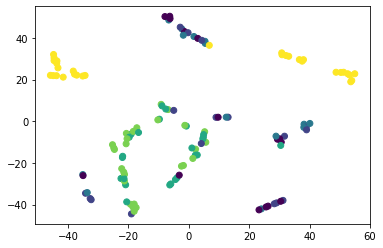

In [32]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=list(labels.numpy()))

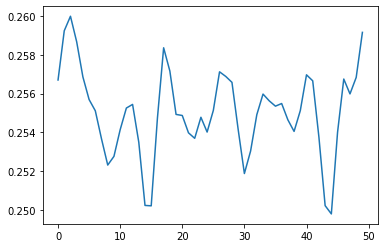

In [36]:
plt.plot(data.numpy()[60,0,:50])

In [11]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [12]:
data.shape

torch.Size([128, 1, 206])